## Imports

In [36]:
"""------------SECTION IMPORTS---------------------"""
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, accuracy_score
import tqdm
'''------------SECTION USER VARIABLES--------------'''
# Define the path to your datafolder below
your_datapath = '../data/'

# Define search space for number of trees in random forest and depth of trees
num_trees_min = 64
num_trees_max = 128

depth_min = 2
depth_max = 7

## Functions

In [2]:


'''------------SECTION FUNCTIONS--------------'''


# Function that creates a pandas dataframe for a single district with columns for the baseline model with semiyearly
# entries
def make_district_df_semiyearly(datapath, district_name):
    """
    Function that creates a pandas dataframe for a single district with columns for the baseline model with
    semiyearly entries

    Parameters
    ----------
    datapath : string
        Path to the datafolder
    district_name : string
        Name of the district

    Returns
    -------
    df : pandas dataframe
    """

    # Read all relevant datasets
    prevalence_df = pd.read_csv(datapath + 'prevalence_estimates.csv', parse_dates=['date'])
    covid_df = pd.read_csv(datapath + 'covid.csv', parse_dates=['date'])
    ipc_df = pd.read_csv(datapath + 'ipc2.csv', parse_dates=['date'])
    risk_df = pd.read_csv(datapath + 'FSNAU_riskfactors.csv', parse_dates=['date'])
    production_df = pd.read_csv(datapath + 'production.csv', parse_dates=['date'])

    # Select data for specific district
    prevalence_df = prevalence_df[prevalence_df['district'] == district_name]
    ipc_df = ipc_df[ipc_df['district'] == district_name]
    risk_df = risk_df[risk_df['district'] == district_name]
    production_df = production_df[production_df['district'] == district_name]

    risk_df = risk_df.groupby(pd.Grouper(key='date', freq='6M')).mean()
    risk_df = risk_df.reset_index()
    risk_df['date'] = risk_df['date'].apply(lambda x: x.replace(day=1))

    covid_df = covid_df.groupby(pd.Grouper(key='date', freq='6M')).sum()
    covid_df = covid_df.reset_index()
    covid_df['date'] = covid_df['date'].apply(lambda x: x.replace(day=1))

    production_df['cropdiv'] = production_df.count(axis=1)

    # Sort dataframes on date
    prevalence_df.sort_values('date', inplace=True)
    covid_df.sort_values('date', inplace=True)
    ipc_df.sort_values('date', inplace=True)
    risk_df.sort_values('date', inplace=True)
    production_df.sort_values('date', inplace=True)

    # Merge dataframes, only joining on current or previous dates as to prevent data leakage
    df = pd.merge_asof(left=prevalence_df, right=ipc_df, direction='backward', on='date')
    df = pd.merge_asof(left=df, right=production_df, direction='backward', on='date')
    df = pd.merge_asof(left=df, right=risk_df, direction='backward', on='date')
    df = pd.merge_asof(left=df, right=covid_df, direction='backward', on='date')

    # Calculate prevalence 6lag
    df['prevalence_6lag'] = df['GAM Prevalence'].shift(1)
    df['next_prevalence'] = df['GAM Prevalence'].shift(-1)

    # Select needed columns
    df = df[['date', 'district', 'GAM Prevalence', 'next_prevalence', 'prevalence_6lag', 'new_cases', 'ndvi_score',
             'phase3plus_perc', 'cropdiv', 'total population']]
    df.columns = ['date', 'district', 'prevalence', 'next_prevalence', 'prevalence_6lag', 'covid', 'ndvi', 'ipc',
                  'cropdiv', 'population']

    # Add month column
    df['month'] = df['date'].dt.month

    # Add target variable: increase for next month prevalence (boolean)
    increase = [False if x[1] < x[0] else True for x in list(zip(df['prevalence'], df['prevalence'][1:]))]
    increase.append(False)
    df['increase'] = increase
    df.iloc[-1, df.columns.get_loc('increase')] = np.nan  # No info on next month

    # Add target variable: increase for next month prevalence (boolean)
    increase_numeric = [x[1] - x[0] for x in list(zip(df['prevalence'], df['prevalence'][1:]))]
    increase_numeric.append(0)
    df['increase_numeric'] = increase_numeric
    df.iloc[-1, df.columns.get_loc('increase_numeric')] = np.nan  # No info on next month

    df.loc[(df.date < pd.to_datetime('2020-03-01')), 'covid'] = 0

    return (df)


# Function that combines the semi-yearly dataset (from the function make_district_df_semiyearly) of all districts
def make_combined_df_semiyearly(datapath):
    """
    Function that creates a pandas dataframe for all districts with columns for the baseline model with semiyearly entries

    Parameters
    ----------
    datapath : string
        Path to the datafolder

    Returns
    -------
    df : pandas dataframe
    """

    prevdf = pd.read_csv(datapath + 'prevalence_estimates.csv', parse_dates=['date'])
    districts = prevdf['district'].unique()

    df_list = []
    for district in districts:
        district_df = make_district_df_semiyearly(datapath, district)
        district_df['district'] = district
        df_list.append(district_df)

    df = pd.concat(df_list, ignore_index=True)
    df['district_encoded'] = df['district'].astype('category').cat.codes

    return df


# Function that returns every possible subset (except the empty set) of the input list l
def subsets(l):
    subset_list = []
    for i in range(len(l) + 1):
        for j in range(i):
            subset_list.append(l[j: i])
    return subset_list




## Dataframe Creation

In [3]:
'''------------SECTION DATAFRAME CREATION--------------'''
# Create the dataframe for all districts
df = make_combined_df_semiyearly(your_datapath)

# Drop every row with missing values
df.dropna(inplace=True)

# Sort dataframe on date and reset the index
df.sort_values('date', inplace=True)
df.reset_index(inplace=True, drop=True)

# Drop disctricts with less than 7 observations: 'Burco', 'Saakow', 'Rab Dhuure', 'Baydhaba', 'Afmadow'
df.drop(df[df['district'].isin(['Burco', 'Saakow', 'Rab Dhuure', 'Baydhaba', 'Afmadow'])].index, inplace=True)




In [4]:
df

,date,district,prevalence,next_prevalence,prevalence_6lag,covid,ndvi,ipc,cropdiv,population,month,increase,increase_numeric,district_encoded
0,2018-01-01,Afgooye,0.351000,0.384859,0.369200,0.0,0.273333,0.00,6.0,309683.385,1,True,0.033859,3
1,2018-01-01,Gebiley,0.197600,0.244319,0.338000,0.0,0.208333,0.13,2.0,146038.500,1,True,0.046719,51
2,2018-01-01,Kurtunwaarey,0.351000,0.446118,0.369200,0.0,0.365000,0.18,5.0,95730.255,1,True,0.095118,61
3,2018-01-01,Qansax Dheere,0.288600,0.509285,0.358800,0.0,0.266667,0.09,7.0,123818.085,1,True,0.220685,71
4,2018-01-01,Waajid,0.486200,0.474895,0.486200,0.0,0.250000,0.11,5.0,85276.755,1,False,-0.011305,81
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
243,2021-01-01,Hargeysa,0.196585,0.267635,0.127787,3583.0,0.200000,0.12,2.0,1044086.000,1,True,0.071050,52
244,2021-01-01,Baraawe,0.491189,0.465542,0.450524,3583.0,0.421667,0.06,5.0,56743.000,1,False,-0.025647,14
245,2021-01-01,Sheikh,0.182837,0.224277,0.145549,3583.0,0.260000,0.18,2.0,71387.000,1,True,0.041440,78
246,2021-01-01,Bulo Burto,0.198074,0.346220,0.455601,3583.0,0.366667,0.12,10.0,90880.000,1,True,0.148145,25


## RF-CV

In [5]:
'''------------SECTION RANDOM FOREST CROSS VALIDATION--------------'''
# WARNING: this process can take some time, since there are a lot of hyperparameters to investigate. The search space can be manually reduced to speed up the process.

# Create empty list to store model scores
parameter_scores = []

# Define target and explanatory variables
X = df.drop(columns=['increase', 'increase_numeric', 'date', 'district', 'prevalence',
                     'next_prevalence'])  # Note that these columns are dropped, the remaining columns are used as explanatory variables
y = df['next_prevalence'].values

In [6]:
X

,prevalence_6lag,covid,ndvi,ipc,cropdiv,population,month,district_encoded
0,0.369200,0.0,0.273333,0.00,6.0,309683.385,1,3
1,0.338000,0.0,0.208333,0.13,2.0,146038.500,1,51
2,0.369200,0.0,0.365000,0.18,5.0,95730.255,1,61
3,0.358800,0.0,0.266667,0.09,7.0,123818.085,1,71
4,0.486200,0.0,0.250000,0.11,5.0,85276.755,1,81
...,...,...,...,...,...,...,...,...
243,0.127787,3583.0,0.200000,0.12,2.0,1044086.000,1,52
244,0.450524,3583.0,0.421667,0.06,5.0,56743.000,1,14
245,0.145549,3583.0,0.260000,0.18,2.0,71387.000,1,78
246,0.455601,3583.0,0.366667,0.12,10.0,90880.000,1,25


In [7]:
y

array([0.38485906, 0.24431911, 0.44611796, 0.50928473, 0.47489491,
       0.53925121, 0.37857746, 0.2386485 , 0.34471067, 0.38304597,
       0.35026078, 0.46372817, 0.43637985, 0.41251811, 0.25058648,
       0.24062519, 0.43096105, 0.39089497, 0.40603569, 0.35804059,
       0.29726064, 0.31423997, 0.38583213, 0.4123023 , 0.39714063,
       0.40774387, 0.33541488, 0.47695342, 0.46854985, 0.28292017,
       0.37111927, 0.23034239, 0.4689021 , 0.47045313, 0.20729391,
       0.30962367, 0.31831561, 0.4388575 , 0.47064018, 0.39837789,
       0.46988452, 0.43567512, 0.39764276, 0.4709407 , 0.43917584,
       0.40971362, 0.20445647, 0.43834035, 0.31494043, 0.28708829,
       0.48161202, 0.35207266, 0.23303072, 0.34409375, 0.31570561,
       0.43652071, 0.47928883, 0.4256324 , 0.19557235, 0.4399318 ,
       0.47319418, 0.43610911, 0.25266592, 0.47094823, 0.32372225,
       0.19516451, 0.22139067, 0.41202916, 0.55458457, 0.34875844,
       0.55128449, 0.46072587, 0.46563963, 0.51133277, 0.53268

In [8]:


for num_trees in range(num_trees_min, num_trees_max):

    for depth in range(depth_min, depth_max):

        # Investigate every subset of explanatory variables
        for features in subsets(X.columns):
            # First CV split. The 99 refers to the first 3 observations for the 33 districts in the data.
            Xtrain = X[:99][features].copy().values
            ytrain = y[:99]
            Xtest = X[99:132][features].copy().values
            ytest = y[99:132]

            # Create a RandomForestRegressor with the selected hyperparameters and random state 0.
            clf = RandomForestRegressor(n_estimators=num_trees, max_depth=depth, random_state=0, n_jobs=-1)

            # Fit to the training data
            clf.fit(Xtrain, ytrain)

            # Make a prediction on the test data
            predictions = clf.predict(Xtest)

            # Calculate mean absolute error
            MAE1 = mean_absolute_error(ytest, predictions)

            # Second CV split. The 132 refers to the first 4 observations for the 33 districts in the data.
            Xtrain = X[:132][features].copy().values
            ytrain = y[:132]
            Xtest = X[132:165][features].copy().values
            ytest = y[132:165]

            # Create a RandomForestRegressor with the selected hyperparameters and random state 0.
            clf = RandomForestRegressor(n_estimators=num_trees, max_depth=depth, random_state=0, n_jobs=-1)

            # Fit to the training data
            clf.fit(Xtrain, ytrain)

            # Make a prediction on the test data
            predictions = clf.predict(Xtest)

            # Calculate mean absolute error
            MAE2 = mean_absolute_error(ytest, predictions)

            # Calculate the mean MAE over the two folds
            mean_MAE = (MAE1 + MAE2) / 2

            # Store the mean MAE together with the used hyperparameters in list
            parameter_scores.append((mean_MAE, num_trees, depth, features))

# Sort the models based on score and retrieve the hyperparameters of the best model
parameter_scores.sort(key=lambda x: x[0])
best_model_score = parameter_scores[0][0]
best_model_trees = parameter_scores[0][1]
best_model_depth = parameter_scores[0][2]
best_model_columns = list(parameter_scores[0][3])

'''------------SECTION FINAL EVALUATION--------------'''
X = df[best_model_columns].values
y = df['next_prevalence'].values

# If there is only one explanatory variable, the values need to be reshaped for the model
if len(best_model_columns) == 1:
    X = X.reshape(-1, 1)

# Peform evaluation on full data
Xtrain = X[:165]
ytrain = y[:165]
Xtest = X[165:]
ytest = y[165:]

clf = RandomForestRegressor(n_estimators=best_model_trees, max_depth=best_model_depth, random_state=0, n_jobs=-1)
clf.fit(Xtrain, ytrain)
predictions = clf.predict(Xtest)

# Calculate MAE
MAE = mean_absolute_error(ytest, predictions)

# Generate boolean values for increase or decrease in prevalence. 0 if next prevalence is smaller than current prevalence, 1 otherwise.
increase = [0 if x < y else 1 for x in df.iloc[165:]['next_prevalence'] for y in df.iloc[165:]['prevalence']]
predicted_increase = [0 if x < y else 1 for x in predictions for y in df.iloc[165:]['prevalence']]

# Calculate accuracy of predicted boolean increase/decrease
acc = accuracy_score(increase, predicted_increase)

# Print model parameters
print('no. of trees: ' + str(best_model_trees) + '\nmax_depth: ' + str(best_model_depth) + '\ncolumns: ' + str(
    best_model_columns))

# Print model scores
print(MAE, acc)

no. of trees: 74
max_depth: 6
columns: ['district_encoded']
0.05629900026844117 0.849862258953168


In [15]:
import pickle

In [16]:
filename = 'finalized_model.sav'
pickle.dump(clf, open(filename, 'wb'))

In [19]:
 # load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
loaded_model.fit(Xtrain, ytrain)
predictions2 = loaded_model.predict(Xtest)
predictions2

array([0.4148018 , 0.42257874, 0.39595439, 0.44748635, 0.36646047,
       0.41325804, 0.31777934, 0.24528278, 0.48025485, 0.44373394,
       0.45020309, 0.35484975, 0.50756738, 0.24048522, 0.4635085 ,
       0.41784431, 0.44111605, 0.41493111, 0.41289312, 0.48474094,
       0.49323732, 0.4279445 , 0.41025708, 0.41917301, 0.34661014,
       0.34838353, 0.22064169, 0.43336775, 0.36898391, 0.25883978,
       0.43303905, 0.32972374, 0.45949714, 0.48025485, 0.36646047,
       0.49323732, 0.41493111, 0.35484975, 0.36898391, 0.4635085 ,
       0.4148018 , 0.39595439, 0.44111605, 0.41784431, 0.24048522,
       0.48474094, 0.41289312, 0.34661014, 0.4279445 , 0.34838353,
       0.41917301, 0.43336775, 0.45949714, 0.42257874, 0.25883978,
       0.32972374, 0.41025708, 0.50756738, 0.45020309, 0.44373394,
       0.44748635, 0.22064169, 0.41325804, 0.24528278, 0.43303905,
       0.31777934])

In [23]:
# Calculate MAE
MAE = mean_absolute_error(ytest, predictions2)

# Generate boolean values for increase or decrease in prevalence. 0 if next prevalence is smaller than current prevalence, 1 otherwise.
increase = [0 if x < y else 1 for x in df.iloc[165:]['next_prevalence'] for y in df.iloc[165:]['prevalence']]
predicted_increase = [0 if x < y else 1 for x in predictions2 for y in df.iloc[165:]['prevalence']]

# Calculate accuracy of predicted boolean increase/decrease
acc = accuracy_score(increase, predicted_increase)

# Print model parameters
print('no. of trees: ' + str(best_model_trees) + '\nmax_depth: ' + str(best_model_depth) + '\ncolumns: ' + str(
    best_model_columns))

# Print model scores
print(MAE, acc)

no. of trees: 74
max_depth: 6
columns: ['district_encoded']
0.05629900026844117 0.849862258953168


In [134]:
from helper_functions import make_confusion_matrix

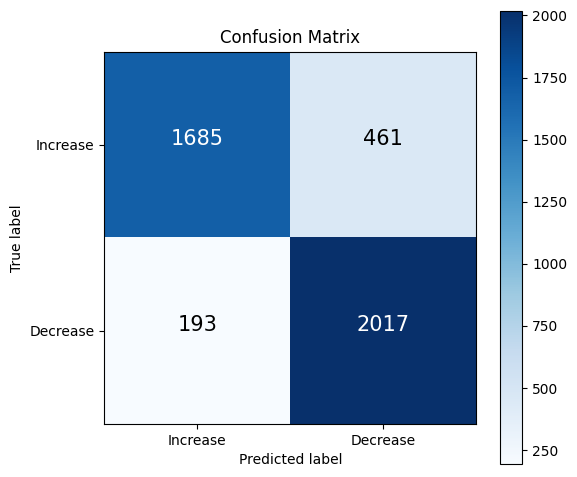

In [135]:
make_confusion_matrix(increase, predicted_increase,figsize=(6,6),classes=["Increase", "Decrease"])

In [148]:
import matplotlib.pyplot as plt
def roc_curve_gen(y_true, y_pred, model_name="Model"):
    """

    Parameters
    ----------
    y_true
    y_pred
    model_name: for title of plot

    Returns
    -------
    ROC curve
    """
    fpr, tpr, threshold = roc_curve(y_true, y_pred)

    plt.plot(fpr, tpr, label="Predicted Increase")

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {model_name}')
    plt.legend(loc="lower right", prop={'size': 8})
    plt.show()


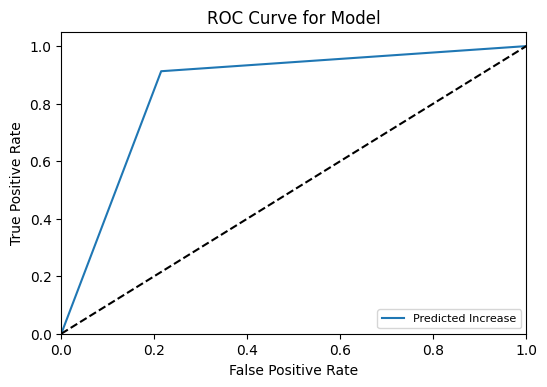

In [149]:
roc_curve_gen(increase, predicted_increase)

In [153]:
from sklearn.metrics import precision_recall_fscore_support
def calculate_results(y_true, y_pred, average="weighted"):
    """
    Calculates model accuracy, precision, recall and f1 score of a binary classification model.

    Args:
        y_true: true labels in the form of a 1D array
        y_pred: predicted labels in the form of a 1D array

    Returns a dictionary of accuracy, precision, recall, f1-score.
    """
    # Calculate model accuracy
    model_accuracy = accuracy_score(y_true, y_pred) * 100
    # Calculate model precision, recall and f1 score using "weighted average
    model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average=average)
    model_results = {"accuracy": model_accuracy,
                     "precision": model_precision,
                     "recall": model_recall,
                     "f1": model_f1}
    return model_results

In [158]:
calculate_results(increase, predicted_increase, average="weighted")

{'accuracy': 84.9862258953168,
 'precision': 0.8549852809761147,
 'recall': 0.849862258953168,
 'f1': 0.8491541221273979}